In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pickle
import re


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import precision_score,f1_score,recall_score,classification_report,accuracy_score
import joblib
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
file_path = '/content/drive/My Drive/FolderName/GUIDE_Test.csv.csv'


In [ ]:
!ls /content/drive/My\ Drive

'Colab Notebooks'		  'Hacker Rank Complete Problems with Solution.gdoc'
'Copy of Copy of itp_day2.ipynb'   new_train_sample.csv
 GUIDE_Test.csv


In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [7]:
from google.colab import drive
drive.mount('/content/drive')

# Verify folder structure
!ls /content/drive/My\ Drive

# Correct path to your file
file_path = '/content/drive/My Drive/FolderName/GUIDE_Test.csv'

# Read the CSV
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/GUIDE_Test.csv')
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'		  'Hacker Rank Complete Problems with Solution.gdoc'
'Copy of Copy of itp_day2.ipynb'   new_train_sample.csv
 GUIDE_Test.csv
              Id  OrgId  IncidentId  AlertId                 Timestamp  \
0  1245540519230    657       11767    87199  2024-06-04T22:56:27.000Z   
1  1400159342154      3       91158   632273  2024-06-03T12:58:26.000Z   
2  1279900255923    145       32247   131719  2024-06-08T03:20:49.000Z   
3    60129547292    222       15294   917686  2024-06-12T12:07:31.000Z   
4   515396080539    363        7615     5944  2024-06-06T17:42:05.000Z   

   DetectorId  AlertTitle           Category                  MitreTechniques  \
0         524         563    LateralMovement      T1021;T1047;T1105;T1569.002   
1           2           2  CommandAndControl                              NaN   
2        2932       10807    LateralMov

In [8]:
df.isnull().sum()

,0
Id,0
OrgId,0
IncidentId,0
AlertId,0
Timestamp,0
DetectorId,0
AlertTitle,0
Category,0
MitreTechniques,2307104
IncidentGrade,0


In [9]:
threshold = len(df) * 0.5
df.dropna(axis=1, thresh=threshold,inplace=True)

print(df.nunique())
# Discard columns that contain only a single unique value.
df = df.loc[:, df.nunique() > 1]

# Checking for duplicate rows and drop those rows
print(df.duplicated().sum())
df.drop_duplicates(keep='first',inplace=True)
print(df.duplicated().sum())

Id                    303220
OrgId                   4400
IncidentId            236267
AlertId               637320
Timestamp             482830
DetectorId              5970
AlertTitle             42265
Category                  19
IncidentGrade              3
EntityType                29
EvidenceRole               2
DeviceId               46260
Sha256                 59446
IpAddress             173786
Url                    65600
AccountSid            215737
AccountUpn            311996
AccountObjectId       204666
AccountName           222314
DeviceName             74791
NetworkMessageId      181759
RegistryKey              995
RegistryValueName        255
RegistryValueData        492
ApplicationId            951
ApplicationName         1514
OAuthApplicationId       380
FileName              122200
FolderPath             43970
ResourceIdName          1109
OSFamily                   5
OSVersion                 43
CountryCode              212
State                   1159
City          

In [10]:
# Inspect columns
print("Columns in the dataframe:", df.columns.tolist())

# Drop only existing columns
columns_to_drop = ['Unnamed: 0', 'IncidentId', 'AlertId', 'Id', 'AccountUpn', 'OSVersion','ResourceType'
                   'EmailClusterId', 'NetworkMessageId', 'AccountObjectId', 'DeviceName',
                   'Sha256', 'OSFamily', 'FolderPath', 'FileName', 'OAuthApplicationId',
                   'ApplicationName', 'ApplicationId', 'RegistryValueData','State','AccountName'
                   'RegistryValueName', 'RegistryKey']

df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Verify remaining columns
print("Remaining columns:", df.columns.tolist())

Columns in the dataframe: ['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId', 'AlertTitle', 'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode', 'State', 'City', 'Usage']
Remaining columns: ['OrgId', 'Timestamp', 'DetectorId', 'AlertTitle', 'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId', 'IpAddress', 'Url', 'AccountSid', 'AccountName', 'RegistryValueName', 'ResourceIdName', 'CountryCode', 'City', 'Usage']


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3922695 entries, 0 to 4147990
Data columns (total 18 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   OrgId              int64 
 1   Timestamp          object
 2   DetectorId         int64 
 3   AlertTitle         int64 
 4   Category           object
 5   IncidentGrade      object
 6   EntityType         object
 7   EvidenceRole       object
 8   DeviceId           int64 
 9   IpAddress          int64 
 10  Url                int64 
 11  AccountSid         int64 
 12  AccountName        int64 
 13  RegistryValueName  int64 
 14  ResourceIdName     int64 
 15  CountryCode        int64 
 16  City               int64 
 17  Usage              object
dtypes: int64(12), object(6)
memory usage: 568.6+ MB


In [12]:
df.isnull().sum()

,0
OrgId,0
Timestamp,0
DetectorId,0
AlertTitle,0
Category,0
IncidentGrade,0
EntityType,0
EvidenceRole,0
DeviceId,0
IpAddress,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3922695 entries, 0 to 4147990
Data columns (total 18 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   OrgId              int64 
 1   Timestamp          object
 2   DetectorId         int64 
 3   AlertTitle         int64 
 4   Category           object
 5   IncidentGrade      object
 6   EntityType         object
 7   EvidenceRole       object
 8   DeviceId           int64 
 9   IpAddress          int64 
 10  Url                int64 
 11  AccountSid         int64 
 12  AccountName        int64 
 13  RegistryValueName  int64 
 14  ResourceIdName     int64 
 15  CountryCode        int64 
 16  City               int64 
 17  Usage              object
dtypes: int64(12), object(6)
memory usage: 568.6+ MB


In [14]:
import pandas as pd

# Ensure Timestamp column is split into Date and Time
df[['Date', 'Time']] = df['Timestamp'].str.replace('T', ' ', regex=False).str.replace('.000Z', '', regex=False).str.split(' ', expand=True)

# Drop the original Timestamp column if no longer needed
df.drop('Timestamp', axis=1, inplace=True)

# Display the updated dataframe
print(df.head())

   OrgId  DetectorId  AlertTitle           Category   IncidentGrade  \
0    657         524         563    LateralMovement  BenignPositive   
1      3           2           2  CommandAndControl  BenignPositive   
2    145        2932       10807    LateralMovement  BenignPositive   
3    222           0           0      InitialAccess   FalsePositive   
4    363          27          18          Discovery  BenignPositive   

          EntityType EvidenceRole  DeviceId  IpAddress     Url  AccountSid  \
0               User     Impacted     98799     360606  160396        2610   
1            Machine     Impacted      1239     360606  160396      441377   
2            Process      Related     98799     360606  160396      441377   
3  CloudLogonSession      Related     98799     360606  160396      441377   
4               User     Impacted     98799     360606  160396      133549   

   AccountName  RegistryValueName  ResourceIdName  CountryCode   City  \
0          863                6

In [15]:
# Extract the 'IncidentGrade' column into df2
df2 = df[['IncidentGrade']]

# Drop the 'IncidentGrade' column from the original df
df = df.drop(columns=['IncidentGrade'])

# Display the updated DataFrames
print("DataFrame df2:")
print(df2)

print("\nUpdated DataFrame df:")
print(df)


DataFrame df2:
          IncidentGrade
0        BenignPositive
1        BenignPositive
2        BenignPositive
3         FalsePositive
4        BenignPositive
...                 ...
4147985  BenignPositive
4147987  BenignPositive
4147988  BenignPositive
4147989   FalsePositive
4147990  BenignPositive

[3922695 rows x 1 columns]

Updated DataFrame df:
         OrgId  DetectorId  AlertTitle           Category         EntityType  \
0          657         524         563    LateralMovement               User   
1            3           2           2  CommandAndControl            Machine   
2          145        2932       10807    LateralMovement            Process   
3          222           0           0      InitialAccess  CloudLogonSession   
4          363          27          18          Discovery               User   
...        ...         ...         ...                ...                ...   
4147985     42         135        7322            Malware            Machine   
414798

In [16]:
# Get unique values in 'IncidentGrade' for df2 this is target table
unique_incident_grades = df2['IncidentGrade'].unique()
print("Unique values in IncidentGrade:")
print(unique_incident_grades)

# Get value counts for 'IncidentGrade' in df2
incident_grade_counts = df2['IncidentGrade'].value_counts()
print("\nValue counts for IncidentGrade:")
print(incident_grade_counts)


Unique values in IncidentGrade:
['BenignPositive' 'FalsePositive' 'TruePositive']

Value counts for IncidentGrade:
IncidentGrade
BenignPositive    1630942
TruePositive      1422856
FalsePositive      868897
Name: count, dtype: int64


Correlations with IncidentGrade:
IncidentGrade        1.000000
EvidenceRole         0.165591
Time                 0.093182
Url                  0.092276
DeviceId             0.088321
RegistryValueName    0.020245
ResourceIdName       0.019779
Usage                0.008991
EntityType          -0.020160
OrgId               -0.032014
Date                -0.062829
AccountName         -0.087373
AccountSid          -0.108328
DetectorId          -0.129639
AlertTitle          -0.139754
IpAddress           -0.161998
City                -0.282935
Category            -0.293005
CountryCode         -0.309924
Name: IncidentGrade, dtype: float64


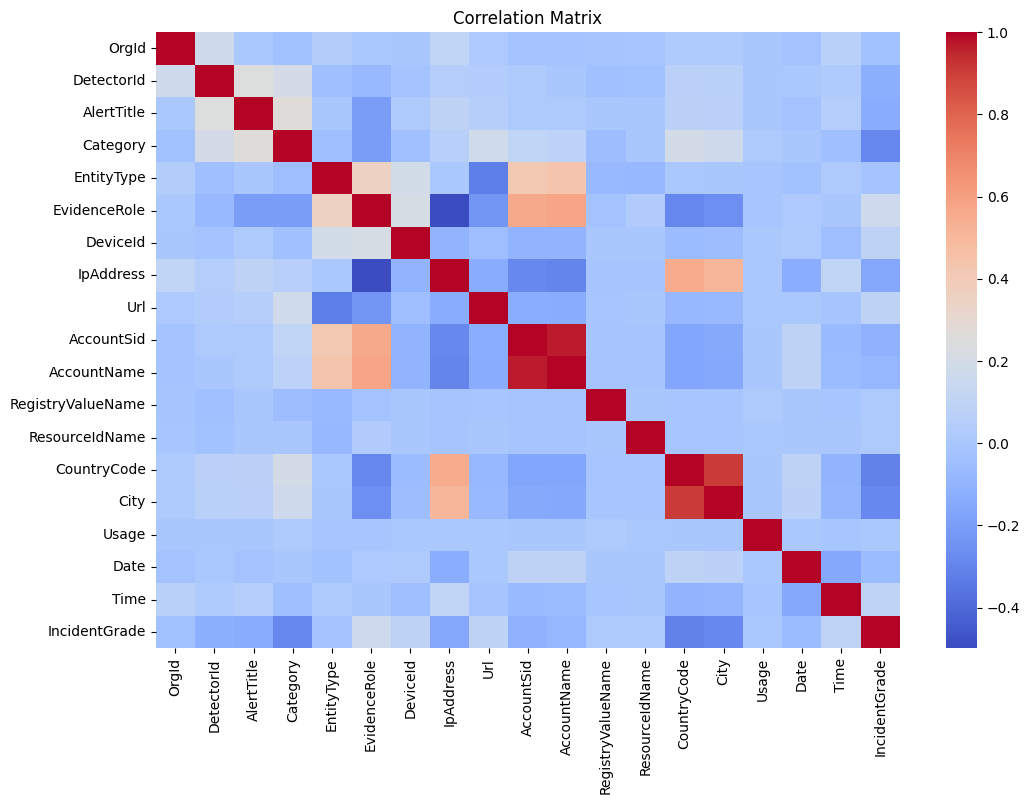

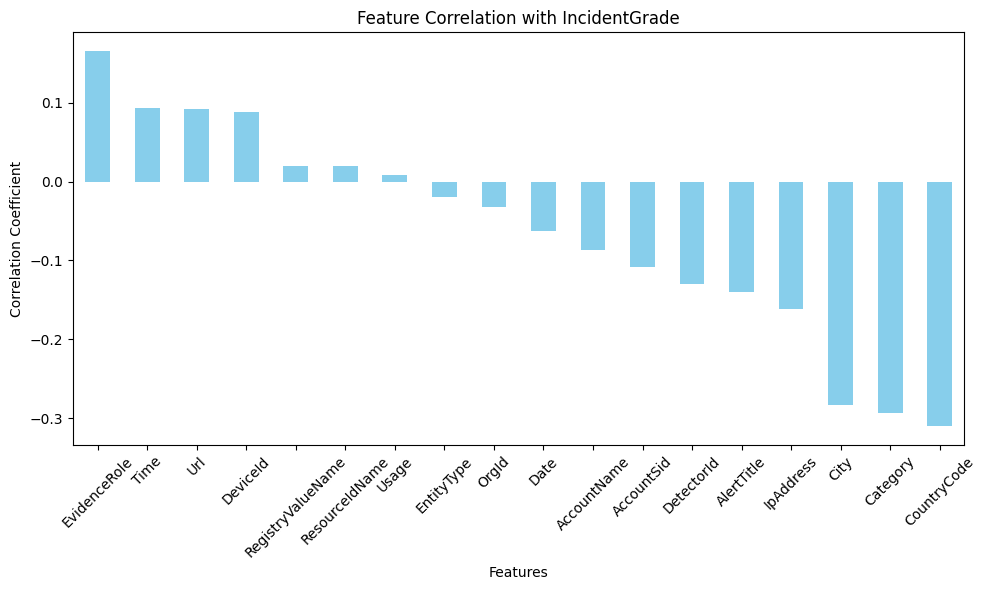

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the two DataFrames have the same length
if len(df) != len(df2):
    raise ValueError("The feature DataFrame (df) and target DataFrame (df2) must have the same number of rows.")

# Add the target column to the feature DataFrame
df['IncidentGrade'] = pd.factorize(df2['IncidentGrade'])[0]

# Convert non-numeric columns in df to numeric using one-hot encoding or factorization
for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.factorize(df[col])[0]

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Extract correlations with the target 'IncidentGrade'
target_correlations = correlation_matrix['IncidentGrade'].sort_values(ascending=False)

# Display the correlations with the target
print("Correlations with IncidentGrade:")
print(target_correlations)

# Plot heatmap for all correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix')
plt.show()

# Plot bar chart for correlation with target
plt.figure(figsize=(10, 6))
target_correlations.drop('IncidentGrade').plot(kind='bar', color='skyblue')
plt.title('Feature Correlation with IncidentGrade')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


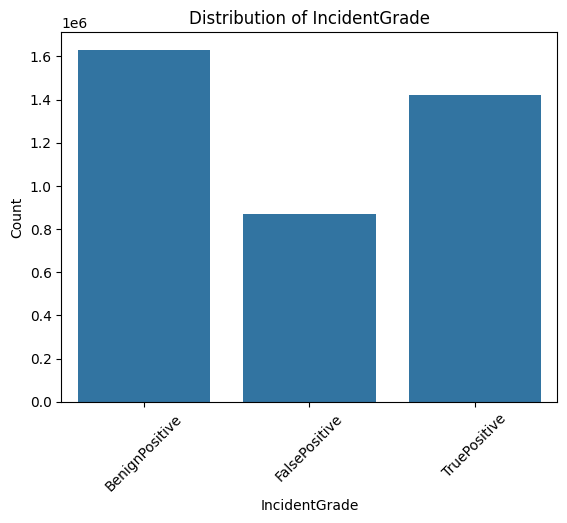

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of the target variable
sns.countplot(x="IncidentGrade", data=df2)  # Use 'x' to specify the column name
plt.title("Distribution of IncidentGrade")
plt.xlabel("IncidentGrade")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 1: Prepare the data
# Assume `df` contains the features and `df2` contains the target
df['IncidentGrade'] = pd.factorize(df2['IncidentGrade'])[0]  # Convert target to numeric

# Separate features and target
X = df.drop(columns=['IncidentGrade'])  # Features
y = df['IncidentGrade']  # Target

# Convert non-numeric columns to numeric using one-hot encoding or factorization
for col in X.select_dtypes(include=['object']).columns:
    X[col] = pd.factorize(X[col])[0]

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Train the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = clf.predict(X_test)

# Step 5: Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Step 6: Feature importance (optional)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Confusion Matrix:
[[478139   5395   5358]
 [  8859 246351   5368]
 [  9864   5577 411898]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    488892
           1       0.96      0.95      0.95    260578
           2       0.97      0.96      0.97    427339

    accuracy                           0.97   1176809
   macro avg       0.96      0.96      0.96   1176809
weighted avg       0.97      0.97      0.97   1176809


Accuracy Score:
0.9656520301935149

Feature Importance:
              Feature  Importance
0               OrgId    0.374438
1          DetectorId    0.150709
2          AlertTitle    0.127403
17               Time    0.076729
16               Date    0.055967
3            Category    0.053504
9          AccountSid    0.032925
10        AccountName    0.025881
7           IpAddress    0.023801
4          EntityType    0.020705
13        CountryCode    0.013095
14               City    0.012844
8    